In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import entsoapi
# from entsoe import EntsoeRawClient
from entsoe import EntsoePandasClient
# import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
%matplotlib inline
client = EntsoePandasClient(api_key=entsoapi.mykey)
print(datetime.today())

2021-04-23 14:18:46.460636


In [2]:
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.axisbelow': True
})

## ARIMA modellek típusai

Az ARIMA modellek azon az elméleti feltevésen alapszanak, hogy minden olyan idősor amelynek egymás utáni értékei FÜGGENEK egymástól, független véletlen ingadozásokból (fehér zajlból) legenerálhatóak(Hulyák, 1977. Ez a modellezés elsősorban a sűrű megfigyeléssel rendelkező változók (pl. árfolyamok) nehezen megragadható szabálytalan ingadozásait, időbeli lefutásait próbálja leírni, alapesetben csupán saját múltbeli értékeik és a véletlenek törvényszerűségei alapján (Hunyadi, 2001).
A szochasztikus idősori modellek integrált autoregresszív és mozgóátlag (rövidítve ARIMA) modellcsaládjának elnevezésében, az AR az autoregresszív, az MA a mozgóátlag jelzőre, az I betű (Integrated) pedig az összegzésre utal. Az autoregresszív (AR) modell, az idősor jelenlegi értékét, saját előző értékeinek függvényében fejezi ki, természetesen, mint sztochasztikus modell, kiegészülve a véletlen ingadozást reprezentáló változóval. Az autoregresszió a regresszió olyan formája, melyben az eredményváltozó más magyarázó változók helyett saját különböző késleltetésű múltbeli értékeihez kapcsolódik. Statisztikai szempontból tehát egyváltozós idősorelemzést végzünk.

### operátorok

B késleltető operátor
$$Bz_t=z_{t-1}$$,
B inverz operátor
$$B^{-1}z_t=z_{t+1}$$,
differencia operátor
$$ \Delta z_t = z_t - z_{t-1}$$,
B és differencia operátor közti különbség
$$ \Delta z_t = (1-B)z_t$$,
.

## Autoregresszív (AR) modell
Az idősor meghatározására p-ed rendű autoregresszív modellt használ:

$$z_t=\phi_1z_{t-1} + \phi_2z_{t-2} + ... + \phi_pz_{t-p} + \alpha_t $$

, ahol az idősor $t$ időszakbeli értékét saját korábbi $t-1, t-2 ... t-p$ értékeivel és egy $\alpha_t$ változó lineáris függvényével kerül kifejezésre.
Leegyszerűsítve az  azt jelenti hogy előrejelzést az idősor saját multbeli értékei alapján akarunk készíteni.

A $\phi(B)$ egy p-ed rendő autoregresszív operátorpolinom:
$$\phi(B) = 1- \phi_1B-\phi_2B^2 - ... - \phi_pB^p$$.

Az AR(1) és AR(2) modellek:
$$z_t = \phi_1z_{t-1} + \alpha_t$$

$$z_t = \phi_1z_{t-1} +\phi_2z_{t-2}+ \alpha_t$$


### Python 
Egy regressziós model, mint például a lineáris regresszió az input változók valamilyen lineáris kombinációjával határozza  meg a kiementi értékeket:
$$\hat{y} = b_0 + b_1*X_1$$


Itt $\hat{y}$  a jóslás, $b_0$ és $b_1$ pedig tényezők, coefficiensek amelyeket az optimalizáció során a modell a tréning adatból határozott meg $X$ pedig bemenő adatsor.

Az a technika olyan  idősorokon alkalmazható, ahogy a megfigyelt értékek  a korábbi időszakok értékéiből származnak, ezeket késleletetett, lag változóknak hívjuk

For example, we can predict the value for the next time step (t+1) given the observations at the last two time steps (t-1 and t-2). As a regression model, this would look as follows:

X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)
1
X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)
Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).



In [3]:
start = pd.Timestamp('202104010000', tz='Europe/Brussels')
end = pd.Timestamp('202104232345', tz='Europe/Brussels')
country_code = 'HU'
load=client.query_load(country_code, start=start,end=end)

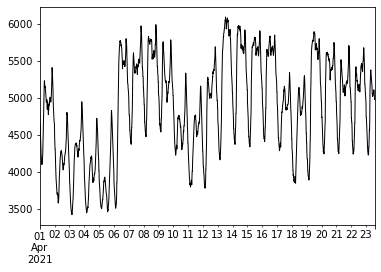

In [4]:
load.plot(color='k', lw=1);
# plt.savefig(r'D:/OneDrive/Corvinus/latex_proj/test/a_0_load.pgf', 
#             dpi=400, 
#             facecolor='w', 
#             edgecolor='w',
#             orientation='portrait',  
#             transparent=True, 
#             bbox_inches=None, pad_inches=0) 

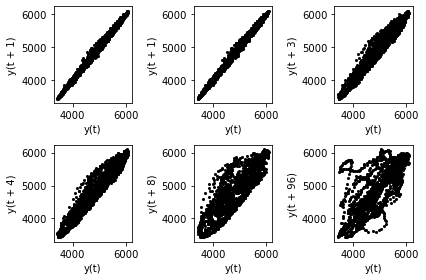

In [5]:
fig, ax = plt.subplots(2,3)
pd.plotting.lag_plot(load, lag=1,  ax = ax[0][0], marker='.', lw=.1, c='k')
pd.plotting.lag_plot(load, lag=1,  ax = ax[0][1], marker='.', lw=.1, c='k')
pd.plotting.lag_plot(load, lag=3,  ax = ax[0][2], marker='.', lw=.1, c='k')
pd.plotting.lag_plot(load, lag=4,  ax = ax[1][0], marker='.', lw=.1, c='k')
pd.plotting.lag_plot(load, lag=8,  ax = ax[1][1], marker='.', lw=.1, c='k')
pd.plotting.lag_plot(load, lag=96, ax = ax[1][2], marker='.', lw=.1, c='k')
plt.tight_layout()
# plt.savefig(r'D:/OneDrive/Corvinus/latex_proj/test/a_1_lagplot.pgf', 
#             dpi=400, 
#             facecolor='w', 
#             edgecolor='w',
#             orientation='portrait',  
#             format=None,            
#             transparent=True, 
#             bbox_inches=None, pad_inches=0) 

In [6]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
df = pd.DataFrame(load)
dataframe = concat([df.shift(2), df.shift(1), df], axis=1)
dataframe.columns = ['t-2','t-1', 't+1']
result = dataframe.corr()
# print(result.round(4))
result

,t-2,t-1,t+1
t-2,1.000000,0.996121,0.987296
t-1,0.996121,1.000000,0.996119
t+1,0.987296,0.996119,1.000000


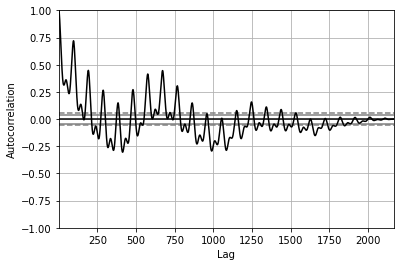

In [7]:
pd.plotting.autocorrelation_plot(load, color='k');
# plt.savefig(r'D:/OneDrive/Corvinus/latex_proj/test/a_2_autocorrplot.pgf', 
#             dpi=400, 
#             facecolor='w', 
#             edgecolor='w',
#             orientation='portrait',  
#             format=None,            
#             transparent=True, 
#             bbox_inches=None, pad_inches=0) 

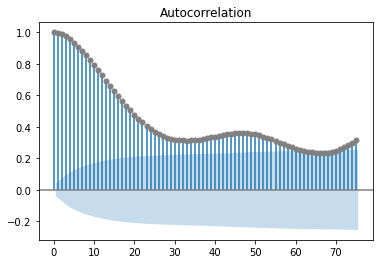

In [8]:
plot_acf(load, lags=75, color='gray', use_vlines=True);
# plt.savefig(r'D:/OneDrive/Corvinus/latex_proj/test/a_3_acfplot75.pgf', 
#             dpi=400, 
#             facecolor='w', 
#             edgecolor='w',
#             orientation='portrait',  
#             transparent=True, 
#             bbox_inches=None, pad_inches=0) 

C:\Users\janos\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


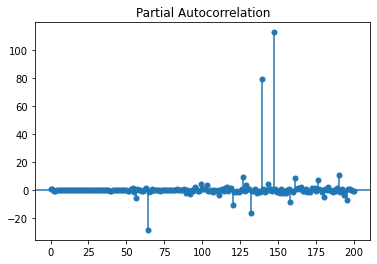

In [9]:

plot_pacf(load, lags=200);

## Mozgóátlagolású (MA) modell
ilyenkor a $z_t$ változót csak az $a_t$ fehér zaj változó $a_t, a_{t-1}, ... , a_{t-q}$ értékeinek véges aggregátumaként állítjuk elő:
$$z_t=a_t-\theta_1a_{t-1}$$

ahol $\theta(B)$ a $q$-ad rendű mozgóátlagolás operátora:
$$\theta(B) = 1-\theta_1B-\theta_2B^2-...-\theta_qB^q$$.

Elsőrendű MA(1) folyamat modellje:
$$z_t=a_t-\theta_1a_{t-a}$$.

## Vegyes ARMA modell
ezek így már két dimenzióval, p-vel és q-val jellemezhetőek, AR és MA tagokat egyaránt tartalmaz.

Ilyenkor a modell magyarázó változójához nem egyszerűen a véletlen változó járul, hanem annak tetszés szerinti mozgóátlagolású aggregátuma.
A modell:
$$z_t=\phi_1z_{t-1} + ... + \phi_pz_{t-p} + a_t - \theta a_{t-1}-...-\theta_q a_{t-q}$$

ARMA(1,1) modell: $$z_t-\phi_qz_{t-1} = a_t-\phi_1a_{t-1}$$

### ARIMA modellek NEM stacionarius idősorokra

### ARIMA modellek NEM stacionarius idősorokra

Az AR, MA és ARMA modellek elsősorban stacionálrius idősorra alkalmazhatóak. Ezeken a nem stacionárius sorokat bizonyos fokú differenciákra hozva stacionárius sort kaphatunk. Ha ezekre a differencákra írjuk fel az ARMA modellt akkor nyerjük az ARIMA modellt.

Ha $w_t = \Delta^d z_t$-vel jelöljük a $z_t$ idősor $d$-edig differenciáinak képzését akkor a  modell:
$$\varphi(B)w_t=\theta(B)a_t$$.
Az eredeti $z_t$ adatokból:
$$\eta(B)z_t=\varphi(B)(1-N)^dz_t=\theta(B)a_t$$,
ahol $\eta(B)$ általánosított autoregresszív operator a $d$-ed fokú differenciák képzését is magába foglalja.

Így az ARIMA modell háromféle dimenzióval ($p, d, q$-val) jellemezhető, ahol $p$ az autoregresszivitás rendje, $d$ a differenciaképzés foka, $q$pedig a mozgóátlagolás rendje. Az Arima modell speciális esete az AR($p,0,0$) MA($0,0,q$) és az ARMA ($p,0,q$). Arima modellel a legtöbb gyakorlati idősor közelíthető $p,d,q$ alacsony (1-2) értékei mellett, kivéve a szabályos ingadozásokat tartalmazó szezonális idősorok.


Leggyakrabban felhasznált ARIMA modelltípusok:

(0,1,1) modell:

(0,2,2) modell

(1,1,1) modell:


### SARIMA modellek
Az idősorokat trend, szezonális és véletlen tényezőkre bonthatjuk, az előrejelzésnél a külön-külön előrejelzett tényezőket egymásra vetítve ( additív vagy multiplikatív módon)  az idősor előrejelzett értékeit kaphatjuk.

Az ARIMA modellek szezonális idősorok közelítésére is alkalmazhatók, az idősor komponensekre bontása nélkül,valamint ennél a módszernél nem kell előre eldönteni, hogy szezonális vagy nem szezonális, hanem a módszer alkalmazása során dől el hogy a konkrét sor milyen modellel írható le optimálisan.

A szezonális ARIMA modellel az idősorokban érvényesülő belső függőséget két irányban vizsgáljuk:
- Az egyik az egymás után következp  időszaki megfigyelések egymásutáni folyamatos függősége, amire az előző típusú modellek is épültek. 
- A másik hatás a különböző évek azonos hidőszakjai között fennálló függőség; amely éppen a szabályos ingadozásokat tartalmazó sorok jellemző sajátossága.

Mindkét függőségi rendszerre felírunk egy ARIMA modellt majd ezeket egymásra építve kapjuk a következő szezonális(multiplikatív) ARIMA modellt:
$$\varphi(B)\Phi(B^s) \Delta^d \Delta^P z_t = \theta(B)\Theta(B^s)a_t$$,

ahol
- $\varphi(B)$ a modell nem szezonális p-ed rendű autoregresszivitását kifejező operátorpolinom,
- $\Phi(B^s)$ a modell szezonális P-ed rendű autoregresszivitását kifejező operátorpolinom,
- $\theta(B)$ a modell nem szezonális q-ad rendű mozgóátlagolását kifejező operátorpolinom,
- $\Theta(B^s)$ a modell szezonális Q-ad rendű mozgóátlagolását kifejező operátorpolinom.

Ebben a modellben egy ($p,d,q$) és egy ($P,D,Q$) dimenziójú modellt építünk egymásra $s$ periódusú szezonalitást feltételezve. Ez így a legáltalánosabb forma amelyet $(p,d,q)(P,D,Q)[S]$-ad rendű ARIMA modellnek nevezünk.


### A modellszerkesztés folyamata

A konkrét idősorra megfelelő modellt egy iterációs eljárással választjuk ki:
1.  Kiindulásként elfogadott ARIMA modellek -> 
2. konrétan kiválasztott modell azonosítása -> 
3. a választott modell paraméterbecslése -> 
4. a modell ellenőrzése -> ha nem akkor vissza 2, ha igen akkor
5. Prognózis

Első lépésként a szóba jöhető modellek körét leszűkítjük.Ilyenkor a vizsgált idősorral végzet előzetes számítások alapján megállapítjuk a legjobban indokolt ARIMA modell vagy modellek p,d, és q értékeit majd kezdőértéket számolunk a paraméterekre ezt a szakaszt nevezzük modell azonosításnak vagy identifikációnak. 
Az azonosítás során az idősorból becsült autokorrelációkra és parciális autokorrelációkra támaszkodunk. 
Ezek a becsült mutatószámok az elméleti függvények közelítése és ezért viselkedésükből következtethetünk az elméleti függvények tulajdonságaira.
A különböző típusú ARIMA folyamatok elméleti autokorreláció és parciális autokorreláció függvényeinek  jellemző sajátosságait viszont ismeretesek.
A kétféle információ összevetése képezi a modellazonosítás alapját.

Az identifikáció szempontjából nem közömbös hogy a becsült mutatószámok nak mekkora a standard hibája.
Ezért ebben a szakaszban a becsült autokorrelációs standard hibáját is megvizsgáljuk. Az azonosítás lezárul ha a modell típusok kiválasztása megtörtént, a paramétereket induló értéket számoltunk és a becsült standard hibák elképzeléseink relatív helyességét alátámasztják.

A második szakaszban határozzuk meg a paraméterek végleges értékét. Ahhoz, hogy a paraméterek hatásos becslését nyerjük, rendelkezésre álló adatainkat és hatékony módon kell felhasználunk a becslés érdekében.

E hatékony módszerek közül mint általában a statisztikai modellek illesztésénél kiemelkednek a  maximális esélyességgen alapuló, és a legkisebb négyzetek elvén alapuló módszerek. 

Problémát jelenthet, hogy a lineáris feltétele nem áll fenn az ARIMA modellek összes paramétereire míg a $\varphi$ autoregressive paraméterekre lineáris függvények nyerünk, a mozgó átlagolás $\theta$ paramétereinek normál egyenletei nem-lineáris függvények. 
Ezért a mozgó átlagolású tagot is tartalmazó általános arima modellek becslését a nemlineáris legkisebb négyzetek valamelyik iterációs módszerével becsüljük. 

Gyakorlati számítások szerint általában 4-6 iterációs lépés biztosítja a konvergenciát.

## Gyakorlati alkalmazások

In [20]:


# create lagged dataset
df = pd.DataFrame(load)
laggedDf = pd.concat([df.shift(2), df.shift(1), df], axis=1)
laggedDf.columns = ['t-2','t-1', 't+1']

In [21]:
# split into train and test sets
X = laggedDf.values
train, test = X[1:len(X)-14], X[len(X)-14:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [22]:
# persistence model
def model_persistence(x):
    return x

$$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2$$.

In [23]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 1100.571


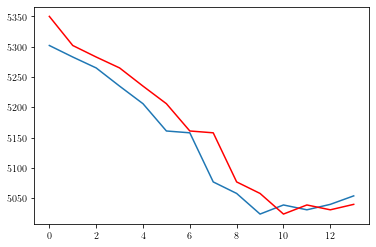

In [24]:
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

### MAE vs MSE vs RMSE
erről is kell írni egy kis paragrafust

## Autoregression model pythonban

Coefficients: [ 2.02531233e+01  1.19645872e+00  6.73558345e-02 -1.83258694e-01
  9.12173941e-02 -2.17489730e-01  2.64509993e-02 -1.10084053e-01
  2.54263241e-01 -2.05304524e-01  5.25719911e-02  7.77411549e-03
 -5.02310665e-02  1.00227005e-01  4.08266956e-03  3.92461856e-02
 -4.84612932e-02  1.13545419e-03 -1.75263866e-01  3.97405275e-02
  1.51103687e-01  2.11213238e-02 -1.53591519e-02  6.70152099e-04
 -1.64724299e-01  8.05430245e-02  6.93495923e-02 -5.90502031e-02
 -5.98602503e-03  1.51996664e-02 -5.83097724e-02  9.02872671e-02
  1.53723891e-01 -2.10745749e-01 -9.71133380e-03  3.63704610e-02
  3.32325423e-02 -1.08184090e-01  4.22868887e-02  8.91077165e-02
 -1.43388504e-01  2.36355757e-01 -8.06061809e-02 -7.91875171e-02
 -1.71605996e-02  2.16899046e-02  7.46576801e-02 -1.20259568e-01
  6.24396050e-02 -4.82762881e-02  1.04828788e-01 -3.38816900e-02
 -7.19257438e-02  2.47432159e-02  7.05673866e-02  6.76034000e-02
 -2.13297159e-01  9.07161110e-02 -4.30039849e-02 -3.72135628e-02
  1.4421470

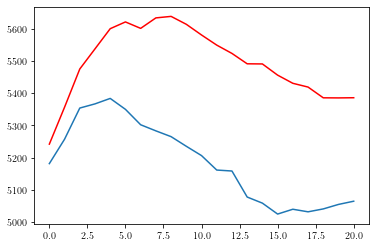

In [26]:

# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# split dataset
X = load.values
train, test = X[1:len(X)-21], X[len(X)-21:]

# train autoregression
model = AutoReg(train, lags=96, old_names=False)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
#     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# MA modell
ugy önmagában ennek nem tul sok értelme van, itt most egy tiszta MA folyamatot generálok le:

$$y_t = 50 + 0.4\varepsilon_{t-1} + 0.3 \varepsilon_{t-2} + \varepsilon_t$$

$$\varepsilon \sim N(0,1)$$

Innováció 1,2 periódussal korábban. 

In [187]:
errors = np.random.normal(0,1,400)
date_index = pd.date_range(start='2021-01-01', end='2021-04-20')
mu=50
series = []
for t in range(1, len(date_index)+1):
    series.append(mu+0.4*errors[t-1]+0.3*errors[t-2]+ errors[t])

In [188]:
series = pd.Series(series, date_index)
series =series.asfreq(pd.infer_freq(series.index))

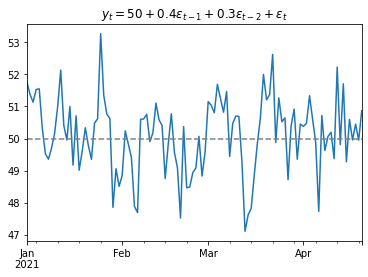

In [189]:
series.plot()
plt.axhline(mu, ls='--', c='grey')
plt.title('$y_t = 50 + 0.4 \\varepsilon_{t-1} + 0.3 \\varepsilon_{t-2} + \\varepsilon_t$');

In [190]:
def calc_corr(series, lag):
    return pearsonr(series[:-lag], series[lag:])[0]

## ACF

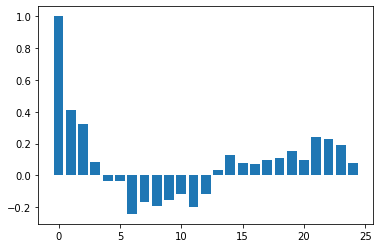

In [194]:

acf_vals = acf(series, fft=False)
num_lags = 25
plt.bar(range(num_lags), acf_vals[:num_lags]);
# ACF -> MA parameter

## PACF

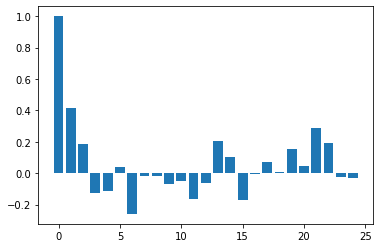

In [195]:
pacf_vals = pacf(series)
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags]);
# PACF: alternating, diminishing, decaying
# PACF -> more evidence that this is MA process

## Get training and testing sets

In [221]:
train_end = datetime(2021, 4, 17)
test_end  = datetime(2021, 4, 21) # csak 2 periódus!

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

In [222]:

model=ARIMA(train_data, order=(0,0,2)) #MA(2)
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -154.619
Date:                Thu, 22 Apr 2021   AIC                            317.239
Time:                        21:00:50   BIC                            327.930
Sample:                    01-01-2021   HQIC                           321.573
                         - 04-17-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1335      0.170    294.479      0.000      49.800      50.467
ma.L1          0.3510      0.094      3.726      0.000       0.166       0.536
ma.L2          0.3634      0.099      3.681      0.0

## Predicted model
$\hat{y}_t = 50 + 0.4082\varepsilon_{t-1} + 0.4347\varepsilon_{t-2}$


In [223]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [224]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [225]:
residuals = test_data - predictions

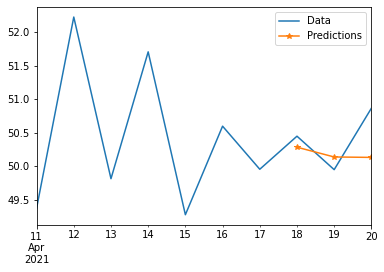

In [234]:
plt.figure()

series[-10:].plot()
predictions.plot(marker='*')

plt.legend(('Data', 'Predictions'));

 Ez csak a MA részt becsli meg, ez egy MA folyamat!

In [231]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)),4))

Mean Absolute Percent Error: 0.0071
Root Mean Squared Error: 0.4465


## SARIMA model alkalmazása villamosenergia terhelési görbére

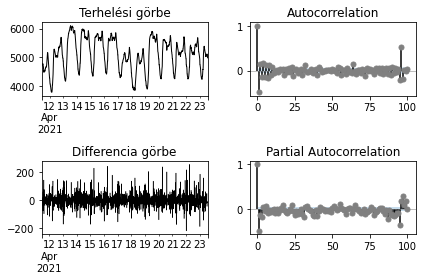

In [206]:
fig, axs = plt.subplots(2,2)

# terhelési
load[1000:].plot(ax= axs[0][0], title='Terhelési görbe',c='k', lw=1)
# differencia
load_fd = load.diff()[1:].diff()[1:]
load_fd[1000:].plot(ax= axs[1][0], title='Differencia görbe',c='k', lw=.5);
axs[1][0].axhline(0, linestyle='--', color='k')
# axs[1][0].xaxis.set_major_locator(mdates.)

#autocorrelation
plot_acf(load_fd, lags= 100, ax =axs[0][1], c='gray', lw=.5, vlines_kwargs={"colors": 'k'});
# partial autocorrelation
plot_pacf(load_fd, lags= 100,ax=axs[1][1],  c='gray', lw=.5, vlines_kwargs={"colors": 'k'})
plt.tight_layout()

plt.savefig(r'D:/OneDrive/Corvinus/latex_proj/test/s_1x4.pgf', 
            dpi=400,facecolor='w',edgecolor='w',
            orientation='portrait',format=None,            
            transparent=True,bbox_inches=None, pad_inches=0) 

In [198]:
train_end = datetime(2021,4,22)
test_end  = datetime(2021,4,23) # csütörtök
train_data = load[:train_end]
test_data  = load[train_end + timedelta(minutes=15):test_end]

In [104]:
train_data

2021-04-01 00:00:00+02:00    4836.0
2021-04-01 00:15:00+02:00    4730.0
2021-04-01 00:30:00+02:00    4670.0
2021-04-01 00:45:00+02:00    4647.0
2021-04-01 01:00:00+02:00    4562.0
                              ...  
2021-04-21 23:00:00+02:00    5068.0
2021-04-21 23:15:00+02:00    5028.0
2021-04-21 23:30:00+02:00    4991.0
2021-04-21 23:45:00+02:00    4952.0
2021-04-22 00:00:00+02:00    4952.0
Freq: 15T, Length: 2017, dtype: float64

In [105]:
test_data

2021-04-22 00:15:00+02:00    4734.0
2021-04-22 00:30:00+02:00    4734.0
2021-04-22 00:45:00+02:00    4683.0
2021-04-22 01:00:00+02:00    4683.0
2021-04-22 01:15:00+02:00    4642.0
                              ...  
2021-04-22 23:00:00+02:00    5075.0
2021-04-22 23:15:00+02:00    5058.0
2021-04-22 23:30:00+02:00    5011.0
2021-04-22 23:45:00+02:00    4932.0
2021-04-23 00:00:00+02:00    4932.0
Freq: 15T, Length: 96, dtype: float64

In [174]:
my_order = (0,1,0) # ar, i, ma  for non seasonal
my_seasonal_order = (1,0,1,96) # ar, i, ma  for seasonal
model = SARIMAX(train_data, order=my_order, seasonal_order = my_seasonal_order)
model_fit = model.fit()

In [255]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  663
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 96)   Log Likelihood               -3301.289
Date:                              Fri, 23 Apr 2021   AIC                           6608.577
Time:                                      19:56:17   BIC                           6622.063
Sample:                                  04-15-2021   HQIC                          6613.804
                                       - 04-22-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L96       0.9972      0.004    264.580      0.000       0.990       1.005
ma.S.L96      -0.8679      0.086    -10.087      0.000      -1.037      -0.699
sigma2       881.5626     75.022     11.751      0.000     734.522    1028.603
===================================================================================
Ljung-Box (L1) (Q):                  96.84   Jarque-Bera (JB):               109.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.34
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [175]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

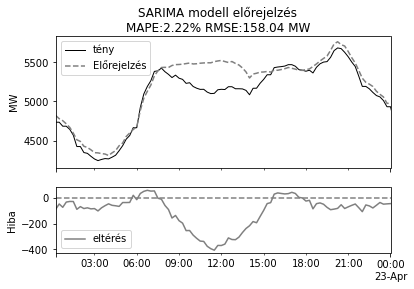

In [253]:
fig, ax= plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

mape=np.mean(abs(residuals/test_data))*100
rmse=np.sqrt(np.mean(residuals**2))
title = 'MAPE:{:.2f}% RMSE:{:.2f} MW'.format(mape, rmse)
plt.suptitle('SARIMA modell előrejelzés\n'+title)

l1= load.loc['2021-04-21':].plot(ls='-',lw=1, c='k', ax=ax[0], label='tény',legend=True)
l2 = predictions.plot(c='grey', ls='--', marker='', ax=ax[0], label='Előrejelzés', legend=True)
l3 = residuals.plot(ax=ax[1], label='eltérés', color='grey', legend=True)
ax[0].set_ylabel('MW');
ax[1].axhline(0, linestyle='--', color='grey');
plt.ylabel('Hiba');
plt.savefig(r'D:/OneDrive/Corvinus/latex_proj/test/s_2x2.pgf', 
            dpi=400,facecolor='w',edgecolor='w',
            orientation='portrait', format=None,            
            transparent=True, bbox_inches=None, pad_inches=0) 

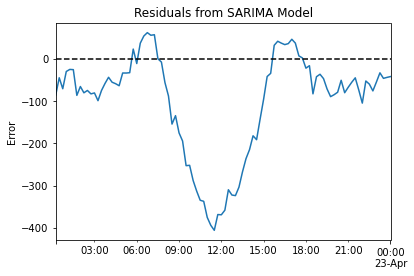

In [177]:
# plt.plot(residuals)
residuals.plot()
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model')
plt.ylabel('Error');
# residuals.. systematic lower bias

In [224]:
print('Mean Absolute Percent Error MAPE: {:.4f} %:'.format(np.mean(abs(residuals/test_data))*100))
print('Root Mean Squared Error:    RMSE: {:.2f} MW'.format(np.sqrt(np.mean(residuals**2))))

Mean Absolute Percent Error MAPE: 2.2185 %:
Root Mean Squared Error:    RMSE:158.04 MW


# Rolling forecast origin

In [238]:
# bázisnap.. 
te = load[test_data.index[0]-timedelta(days=7):test_data.index[0]-timedelta(minutes=15)]

In [239]:
rolling_predictions = test_data.copy()
baseday=train_end-timedelta(days=7)
for train_end in test_data.index:
    print(train_end)
    train_data = load[baseday:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

2021-04-22 00:15:00+02:00
2021-04-22 00:30:00+02:00
2021-04-22 00:45:00+02:00
2021-04-22 01:00:00+02:00
2021-04-22 01:15:00+02:00
2021-04-22 01:30:00+02:00
2021-04-22 01:45:00+02:00
2021-04-22 02:00:00+02:00
2021-04-22 02:15:00+02:00
2021-04-22 02:30:00+02:00
2021-04-22 02:45:00+02:00
2021-04-22 03:00:00+02:00
2021-04-22 03:15:00+02:00
2021-04-22 03:30:00+02:00
2021-04-22 03:45:00+02:00
2021-04-22 04:00:00+02:00
2021-04-22 04:15:00+02:00
2021-04-22 04:30:00+02:00
2021-04-22 04:45:00+02:00
2021-04-22 05:00:00+02:00
2021-04-22 05:15:00+02:00
2021-04-22 05:30:00+02:00
2021-04-22 05:45:00+02:00
2021-04-22 06:00:00+02:00
2021-04-22 06:15:00+02:00
2021-04-22 06:30:00+02:00
2021-04-22 06:45:00+02:00
2021-04-22 07:00:00+02:00
2021-04-22 07:15:00+02:00
2021-04-22 07:30:00+02:00
2021-04-22 07:45:00+02:00
2021-04-22 08:00:00+02:00
2021-04-22 08:15:00+02:00
2021-04-22 08:30:00+02:00
2021-04-22 08:45:00+02:00
2021-04-22 09:00:00+02:00
2021-04-22 09:15:00+02:00
2021-04-22 09:30:00+02:00
2021-04-22 0

In [240]:
rolling_residuals = test_data - rolling_predictions

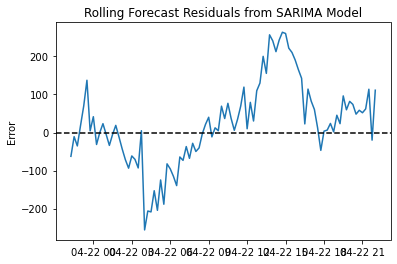

In [241]:
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model')
plt.ylabel('Error');

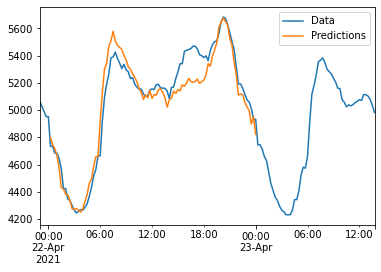

In [242]:
load.loc['2021-04-21 23:00':'2021-04-23'].plot()
rolling_predictions.plot()
plt.legend(('Data', 'Predictions'));

In [243]:
print('Mean Absolute Percent Error {:.4f} %:'.format(np.mean(abs(rolling_residuals/test_data))*100))
print('Root Mean Squared Error: {:.2f} MW'.format(np.sqrt(np.mean(rolling_residuals**2))))

Mean Absolute Percent Error 1.6053 %:
Root Mean Squared Error: 110.72 MW


<AxesSubplot:>

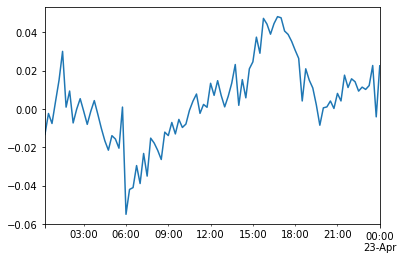

In [244]:
(rolling_residuals/test_data).plot()

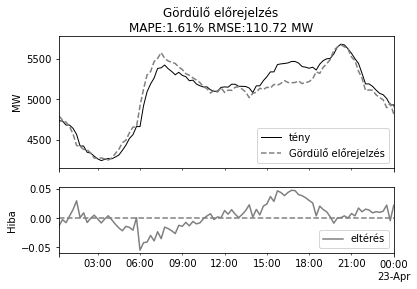

In [254]:
fig, ax= plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

mape=np.mean(abs(rolling_residuals/test_data))*100
rmse=np.sqrt(np.mean(rolling_residuals**2))
title = 'MAPE:{:.2f}% RMSE:{:.2f} MW'.format(mape, rmse)
plt.suptitle('Gördülő előrejelzés\n'+title)
load.loc['2021-04-21':].plot(ls='-',lw=1, c='k', ax=ax[0], label='tény',legend=True)
rolling_predictions.plot(c='grey', ls='--', marker='', ax=ax[0], label='Gördülő előrejelzés', legend=True)
(rolling_residuals/test_data).plot(ax=ax[1], label='eltérés', color='grey', legend=True)
ax[0].set_ylabel('MW');
ax[1].axhline(0, linestyle='--', color='grey');
plt.ylabel('Hiba');
plt.savefig(r'D:/OneDrive/Corvinus/latex_proj/test/s_3x2.pgf', 
            dpi=400,facecolor='w',edgecolor='w',
            orientation='portrait', format=None,            
            transparent=True, bbox_inches=None, pad_inches=0) 